<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Developing-a-Model" data-toc-modified-id="Developing-a-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Developing a Model</a></span><ul class="toc-item"><li><span><a href="#Create-a-training-set" data-toc-modified-id="Create-a-training-set-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Create a training set</a></span></li><li><span><a href="#Linear-Regression---Sklearn" data-toc-modified-id="Linear-Regression---Sklearn-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Linear Regression - Sklearn</a></span><ul class="toc-item"><li><span><a href="#Create-the-model" data-toc-modified-id="Create-the-model-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Create the model</a></span></li><li><span><a href="#Evaluating-the-model" data-toc-modified-id="Evaluating-the-model-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Evaluating the model</a></span></li></ul></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span><ul class="toc-item"><li><span><a href="#Create-the-model" data-toc-modified-id="Create-the-model-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Create the model</a></span></li><li><span><a href="#Find-the-optimal-model-depth" data-toc-modified-id="Find-the-optimal-model-depth-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Find the optimal model depth</a></span></li><li><span><a href="#Without-specifying-the-maximum-number-of-nodes" data-toc-modified-id="Without-specifying-the-maximum-number-of-nodes-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Without specifying the maximum number of nodes</a></span><ul class="toc-item"><li><span><a href="#Predicting-Selling-Prices" data-toc-modified-id="Predicting-Selling-Prices-1.3.3.1"><span class="toc-item-num">1.3.3.1&nbsp;&nbsp;</span>Predicting Selling Prices</a></span></li></ul></li><li><span><a href="#Specifying-the-maximum-number-of-nodes---Bias-Variance-Trade-off" data-toc-modified-id="Specifying-the-maximum-number-of-nodes---Bias-Variance-Trade-off-1.3.4"><span class="toc-item-num">1.3.4&nbsp;&nbsp;</span>Specifying the maximum number of nodes - Bias Variance Trade-off</a></span></li></ul></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Random Forest</a></span></li></ul></li></ul></div>

In [1]:
%load_ext autoreload

# Import libraries necessary for this project
import numpy as np
import pandas as pd
from scipy import stats
from pandas_datareader import data
from pylab import rcParams
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
import os
import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
import itertools

# Pretty display for notebooks
%matplotlib inline

# Import supplementary visualizations code visuals.py
import visuals as vs

# Hide sklearn future warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the data
data_model = pd.read_csv('data/processed/hong-kong-property-prices-model.csv',index_col='date',parse_dates=True,infer_datetime_format=True)

In [3]:
# We are going to focus on a period when the price increase was fairly consistent
date_from = '2009-01-01'
date_until = '2015-12-31'

# filter the dataset
data_model = data_model[data_model.transaction_year >= int(re.match('\d{4}', date_from).group())]
data_model = data_model[data_model.transaction_year <= int(re.match('\d{4}', date_until).group())]

print(len(data_model))
data_model.head()

183807


,price,saleablearea,grossarea,regioncode,floor,yearofcompletion,transaction_year,netPricePerSqf
date,,,,,,,,
2009-01-02,1230000,386,480,216,22,1977,2009,3186
2009-01-02,3370000,874,1175,408,32,2002,2009,3855
2009-01-02,1200000,508,642,402,12,1998,2009,2362
2009-01-02,1560000,410,539,307,24,1991,2009,3804
2009-01-02,1440000,467,599,406,6,1989,2009,3083


In [4]:
# remove outliers
data_model = data_model[(np.abs(stats.zscore(data_model)) < 3).all(axis=1)]

In [5]:
data_model.describe()

,price,saleablearea,grossarea,regioncode,floor,yearofcompletion,transaction_year,netPricePerSqf
count,1.774780e+05,177478.000000,177478.000000,177478.000000,177478.000000,177478.000000,177478.000000,177478.000000
mean,3.041170e+06,500.211992,648.481271,331.049313,15.941711,1991.477513,2011.355267,6023.716348
std,1.705854e+06,156.449112,200.241191,86.772416,10.662306,10.269693,1.935113,2481.833101
min,1.000000e+05,141.000000,183.000000,102.000000,0.000000,1961.000000,2009.000000,264.000000
25%,1.800000e+06,391.000000,508.000000,302.000000,7.000000,1985.000000,2010.000000,4122.000000
50%,2.610000e+06,476.000000,613.000000,402.000000,15.000000,1991.000000,2011.000000,5625.000000
75%,3.880000e+06,579.000000,738.000000,403.000000,23.000000,1999.000000,2013.000000,7591.000000
max,1.220000e+07,1171.000000,1540.000000,410.000000,51.000000,2017.000000,2015.000000,14049.000000


In [6]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 177478 entries, 2009-01-02 to 2015-12-31
Data columns (total 8 columns):
price               177478 non-null int64
saleablearea        177478 non-null int64
grossarea           177478 non-null int64
regioncode          177478 non-null int64
floor               177478 non-null int64
yearofcompletion    177478 non-null int64
transaction_year    177478 non-null int64
netPricePerSqf      177478 non-null int64
dtypes: int64(8)
memory usage: 12.2 MB


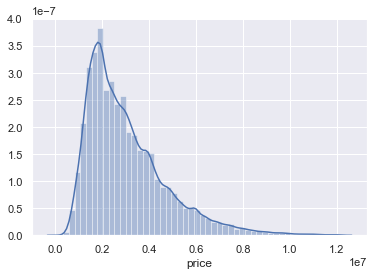

In [7]:
sns.distplot(data_model['price'])

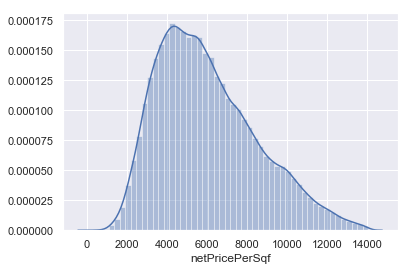

In [8]:
sns.distplot(data_model['netPricePerSqf'])

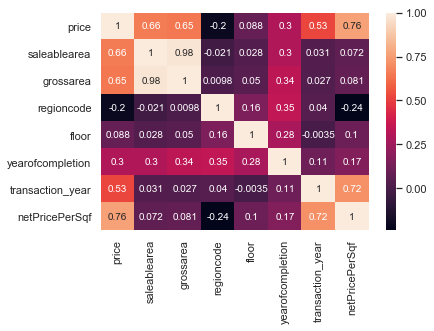

In [9]:
sns.heatmap(data_model.corr(),annot=True)

# Developing a Model
## Create a training set

In [10]:
# Create target object and call it y
y_lr = data_model['price'].to_frame()

# Model features
X_lr = data_model.drop(['netPricePerSqf','grossarea','floor','regioncode','price','yearofcompletion'], axis = 1)

In [11]:
# Import 'train_test_split'
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
train_X_lr, val_X_lr, train_y_lr, val_y_lr = train_test_split(X_lr, y_lr, test_size=0.3, random_state = 42)

# Success
print("Training and testing split was successful.")

Training and testing split was successful.


## Linear Regression - Sklearn
### Create the model

In [12]:
from sklearn.linear_model import LinearRegression

# Create a linear regression model
lm = LinearRegression()

# Fit the model with the training data
lm.fit(train_X_lr, train_y_lr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [13]:
print(lm.intercept_)
cdf = pd.DataFrame(lm.coef_.flatten(),X_lr.columns,columns=['Coeff by columns'])
cdf

[-8.97172602e+08]


,Coeff by columns
saleablearea,7019.397100
transaction_year,445819.041046


In [14]:
# Predictions
predictions_lr = lm.predict(val_X_lr)
predictions_lr[:5].astype('int')

array([[4739677],
       [2106879],
       [ 281836],
       [2475484],
       [1485749]])

In [15]:
# real values
val_y_lr.head()

,price
date,
2015-05-29,5860000
2009-08-20,2670000
2009-11-16,860000
2010-06-09,3200000
2010-02-09,1800000


Text(0, 0.5, 'Predicted Values')

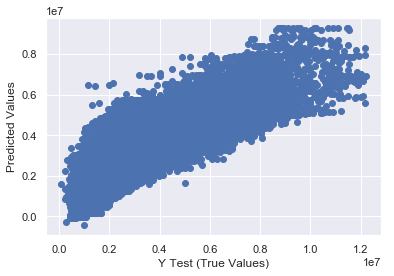

In [16]:
plt.scatter(val_y_lr,predictions_lr)
plt.xlabel('Y Test (True Values)')
plt.ylabel('Predicted Values')

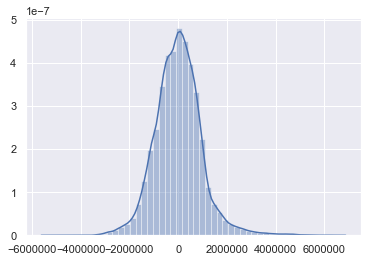

In [17]:
# Residuals
sns.distplot(val_y_lr-predictions_lr)

### Evaluating the model

In [18]:
from sklearn import metrics
print('mean absolute error: ',metrics.mean_absolute_error(val_y_lr,predictions_lr).astype('int'))
print('mean squared error: ',metrics.mean_squared_error(val_y_lr,predictions_lr).astype('int'))
print('root mean squared error:',np.sqrt(metrics.mean_squared_error(val_y_lr,predictions_lr)).astype('int'))

mean absolute error:  718430
mean squared error:  -2147483648
root mean squared error: 956742


In [19]:
metrics.explained_variance_score(val_y_lr,predictions_lr).round(4)

0.6863

## DecisionTreeRegressor
### Create the model

In [20]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [21]:
# Create target object and call it y
y = data_model['price'].values
print(type(y))

# Model features
X = data_model.drop('price', axis = 1).drop('netPricePerSqf', axis = 1)

<class 'numpy.ndarray'>


In [22]:
X.head()

,saleablearea,grossarea,regioncode,floor,yearofcompletion,transaction_year
date,,,,,,
2009-01-02,386,480,216,22,1977,2009
2009-01-02,874,1175,408,32,2002,2009
2009-01-02,508,642,402,12,1998,2009
2009-01-02,410,539,307,24,1991,2009
2009-01-02,467,599,406,6,1989,2009


In [23]:
# Import 'train_test_split'
from sklearn.model_selection import train_test_split

# Shuffle and split the data into training and testing subsets
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state = 42)

# Success
print("Training and testing split was successful.")

Training and testing split was successful.


### Find the optimal model depth

In [24]:
from sklearn.metrics import mean_absolute_error

for max_leaf_nodes in [50,100, 500, 1000,5000,10000,15000,20000,25000,30000]:
    my_mae = vs.get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(max_leaf_nodes, my_mae))

Max leaf nodes: 50  		 Mean Absolute Error:  548339
Max leaf nodes: 100  		 Mean Absolute Error:  494314
Max leaf nodes: 500  		 Mean Absolute Error:  381063
Max leaf nodes: 1000  		 Mean Absolute Error:  337495
Max leaf nodes: 5000  		 Mean Absolute Error:  274055
Max leaf nodes: 10000  		 Mean Absolute Error:  267964
Max leaf nodes: 15000  		 Mean Absolute Error:  271604
Max leaf nodes: 20000  		 Mean Absolute Error:  276022
Max leaf nodes: 25000  		 Mean Absolute Error:  279845
Max leaf nodes: 30000  		 Mean Absolute Error:  283253


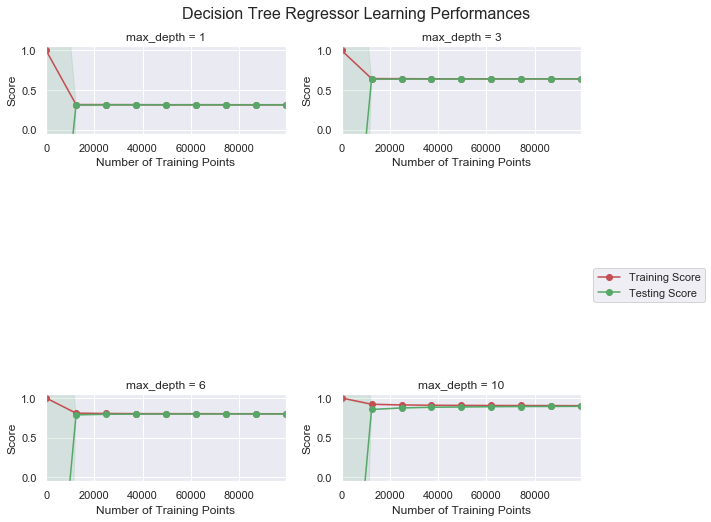

In [25]:
# Produce learning curves for varying training set sizes and maximum depths
vs.ModelLearning(train_X, train_y)

In [26]:
# vs.ModelComplexity(train_X, train_y)

### Without specifying the maximum number of nodes

In [27]:
# Fit the training data to the model using grid search
reg_DecisionTreeRegressor = fit_model_DecisionTreeRegressor(train_X, train_y)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg_DecisionTreeRegressor.get_params()['max_depth']))

Parameter 'max_depth' is 10000 for the optimal model.


In [28]:
# Define the model
dt_model = DecisionTreeRegressor(random_state=1)

# fit the model
dt_model.fit(train_X, train_y)

# Make validation predictions and calculate mean absolute error
val_predictions = dt_model.predict(val_X)
print("Validation Mean Absolute Error when not specifying max_leaf_nodes: ",metrics.mean_absolute_error(val_y,val_predictions).astype('int'))
print('mean squared error: ',metrics.mean_squared_error(val_y_lr,val_predictions).astype('int'))
print('root mean squared error:',np.sqrt(metrics.mean_squared_error(val_y_lr,val_predictions)).astype('int'))

Validation Mean Absolute Error when not specifying max_leaf_nodes:  300900
mean squared error:  -2147483648
root mean squared error: 463732


### Specifying the maximum number of nodes - Bias Variance Trade-off

In [ ]:
# Fit the training data to the model using grid search
reg_DecisionTreeRegressor_max_leaf = fit_model_DecisionTreeRegressor_max_leaf(train_X, train_y)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg_DecisionTreeRegressor_max_leaf.get_params()['max_depth']))

In [29]:
# Using best value for max_leaf_nodes
dt_model_max_leaf_nodes = DecisionTreeRegressor(max_leaf_nodes=10000,random_state=1)

# fit the model
dt_model_max_leaf_nodes.fit(train_X, train_y)

val_predictions_max_leaf_nodes = dt_model_max_leaf_nodes.predict(val_X)

# Calculate the performance of the model on the validation data
print("Validation Mean Absolute Error when specifying max_leaf_nodes: ",metrics.mean_absolute_error(val_y,val_predictions_max_leaf_nodes).astype('int'))
print('mean squared error: ',metrics.mean_squared_error(val_y,val_predictions_max_leaf_nodes).astype('int'))
print('root mean squared error:',np.sqrt(metrics.mean_squared_error(val_y,val_predictions_max_leaf_nodes)).astype('int'))

Validation Mean Absolute Error when specifying max_leaf_nodes:  268212
mean squared error:  -2147483648
root mean squared error: 425943


In [30]:
# Make validation predictions
val_predictions_max_leaf_nodes = dt_model_max_leaf_nodes.predict(val_X)

#### Predicting Selling Prices

In [31]:
train_X.columns

Index(['saleablearea', 'grossarea', 'regioncode', 'floor', 'yearofcompletion',
       'transaction_year'],
      dtype='object')

In [32]:
train_X.head()

,saleablearea,grossarea,regioncode,floor,yearofcompletion,transaction_year
date,,,,,,
2013-01-09,722,904,302,26,1987,2013
2011-06-16,394,526,308,23,1985,2011
2009-06-17,393,526,302,38,2001,2009
2012-05-04,747,943,409,5,1994,2012
2012-07-19,350,454,217,6,1966,2012


In [33]:
# Produce a matrix of fictionnal flats
client_data = [[722,904,302,26,1987,2013], # Client 1
               [394,526,308,23,1985,2011], # Client 2
               [393,526,302,38,2001,2009]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $7,880,000.00
Predicted selling price for Client 2's home: $2,000,000.00
Predicted selling price for Client 3's home: $2,500,000.00


In [35]:
vs.PredictTrials(X, y, vs.fit_model_DecisionTreeRegressor, client_data)

Trial 1: $7,278,779.34
Trial 2: $6,027,026.02
Trial 3: $5,950,769.23
Trial 4: $6,469,090.91
Trial 5: $5,640,221.61
Trial 6: $7,051,691.73
Trial 7: $6,630,952.38
Trial 8: $6,575,454.55
Trial 9: $6,608,636.36
Trial 10: $6,495,000.00

Range in prices: $1,638,557.74


In [36]:
int(data_model.price.median())

2610000

## Random Forest

In [37]:
from sklearn.ensemble import RandomForestRegressor

In [38]:
# Define the model. Set random_state to 1
rf_model = RandomForestRegressor(random_state=0)

# fit the model
rf_model.fit(train_X, train_y)

rf_val_predictions = rf_model.predict(val_X)

# Calculate the performance of the model on the validation data
print("Validation Mean Absolute Error: ",mean_absolute_error(val_y,rf_val_predictions).astype('int'))
print('mean squared error: ',metrics.mean_squared_error(val_y,rf_val_predictions).astype('int'))
print('root mean squared error:',np.sqrt(metrics.mean_squared_error(val_y,rf_val_predictions)).astype('int'))

Validation Mean Absolute Error:  251752
mean squared error:  -2147483648
root mean squared error: 374553


In [40]:
def PredictTrials(X, y, fitter, data):
    """ Performs trials of fitting and predicting data. """

    # Store the predicted prices
    prices = []

    for k in range(10):
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, \
            test_size = 0.2, random_state = k)

        # Fit the data
        reg = fitter(X_train, y_train)

        # Make a prediction
        pred = reg.predict([data[0]])[0]
        prices.append(pred)

        # Result
        print("Trial {}: ${:,.2f}".format(k+1, pred))

    # Display price range
    print("\nRange in prices: ${:,.2f}".format(max(prices) - min(prices)))


In [41]:
PredictTrials(X, y, vs.fit_model_RandomForestRegressor, client_data)

Trial 1: $6,544,621.26
Trial 2: $6,435,645.49
Trial 3: $6,570,147.39
Trial 4: $6,645,710.99
Trial 5: $6,453,315.91
Trial 6: $6,566,992.00
Trial 7: $6,947,129.85
Trial 8: $6,440,541.72
Trial 9: $6,379,343.69
Trial 10: $6,623,853.40

Range in prices: $567,786.16
